# Testing around #
Just some random testing, nothing with a structure to follow.
Under 'Three-qubit bit-flip' is a working bit-flip code using 2 ancilla qubits,
and below that is the same but only using a single ancilla qubit.

In [2]:
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer
    )

from qiskit.visualization import plot_histogram

In [71]:
# Define the circuit
circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1);
circuit.measure([0,1], [0,1])

In [72]:
circuit.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [73]:
help( circuit.measure )

Help on method measure in module qiskit.circuit.measure:

measure(qubit, cbit) method of qiskit.circuit.quantumcircuit.QuantumCircuit instance
    Measure quantum bit into classical bit (tuples).
    
    Args:
        qubit (QuantumRegister|list|tuple): quantum register
        cbit (ClassicalRegister|list|tuple): classical register
    
    Returns:
        qiskit.Instruction: the attached measure instruction.
    
    Raises:
        CircuitError: if qubit is not in this circuit or bad format;
            if cbit is not in this circuit or not creg.




Total count for 00 and 11 are: {'00': 481, '11': 519}


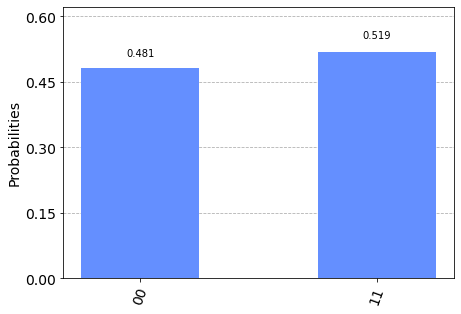

In [74]:
simulator = Aer.get_backend('qasm_simulator')
job = execute( circuit, simulator, shots=1000 )
result = job.result()
counts = result.get_counts( circuit )
print("\nTotal count for 00 and 11 are:", counts)
plot_histogram(counts)

In [3]:
# QEC Example
from qiskit import QuantumRegister, ClassicalRegister

cq = QuantumRegister(2,'code_qubit')
lq = QuantumRegister(1,'ancilla_qubit')
sb = ClassicalRegister(1,'syndrome_bit')
qc = QuantumCircuit(cq,lq,sb)
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.measure(lq,sb)
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
qc.draw()


{'0': 1024}


code_qubit_0: ──■──────────
                   │          
   code_qubit_1: ──┼────■─────
                 ┌─┴─┐┌─┴─┐┌─┐
ancilla_qubit_0: ┤ X ├┤ X ├┤M├
                 └───┘└───┘└╥┘
 syndrome_bit: 1/═══════════╩═
                            0

# Three-qubit bit-flip #

In [76]:
qReg = QuantumRegister(3, 'code_qubit')
aReg = QuantumRegister(2, 'ancilla_qubit')
cReg1 = ClassicalRegister(2, 'syndrome_bit')
#cReg2 = ClassicalRegister(1, 'syndrome_bit2')
readout = ClassicalRegister(3, 'readout')
circuit = QuantumCircuit( cReg1, readout, aReg, qReg )

# Encoding
circuit.h(qReg[0])
circuit.cx(qReg[0], qReg[1])
circuit.cx(qReg[0], qReg[2])

# Manual errors
circuit.x(qReg[2])

# Syndrome measurements Z1Z2
circuit.cx(qReg[0], aReg[0])
circuit.cx(qReg[1], aReg[0])
circuit.measure(aReg[0], cReg1[0])

# Syndrome measurement Z2Z3
circuit.cx(qReg[1], aReg[1])
circuit.cx(qReg[2], aReg[1])
circuit.measure(aReg[1], cReg1[1])

# Conditional corrections
circuit.x(qReg[0]).c_if(cReg1, 1) # The value can be written in base 10, but is interpreted as binary (to allow e.g. 01)
circuit.x(qReg[1]).c_if(cReg1, 3)
circuit.x(qReg[2]).c_if(cReg1, 2)

# Readout the state
circuit.measure(qReg, readout)


counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
circuit.draw()


{'111 10': 482, '000 10': 542}


┌───┐┌───┐┌─┐                              »
ancilla_qubit_0: ───────────────┤ X ├┤ X ├┤M├──────────────────────────────»
                                └─┬─┘└─┬─┘└╥┘┌───┐┌───┐┌─┐                 »
ancilla_qubit_1: ─────────────────┼────┼───╫─┤ X ├┤ X ├┤M├─────────────────»
                 ┌───┐            │    │   ║ └─┬─┘└─┬─┘└╥┘ ┌───┐        ┌─┐»
   code_qubit_0: ┤ H ├──■────■────■────┼───╫───┼────┼───╫──┤ X ├────────┤M├»
                 └───┘┌─┴─┐  │         │   ║   │    │   ║  └─┬─┘  ┌───┐ └╥┘»
   code_qubit_1: ─────┤ X ├──┼─────────■───╫───■────┼───╫────┼────┤ X ├──╫─»
                      └───┘┌─┴─┐┌───┐      ║        │   ║    │    └─┬─┘  ║ »
   code_qubit_2: ──────────┤ X ├┤ X ├──────╫────────■───╫────┼──────┼────╫─»
                           └───┘└───┘      ║            ║ ┌──┴──┐┌──┴──┐ ║ »
 syndrome_bit: 2/══════════════════════════╩════════════╩═╡ = 1 ╞╡ = 3 ╞═╬═»
                                           0            1 └─────┘└─────┘ ║ »
      readout: 3/════════════════════════════════════════════════════════╩═»
                                                                         0 »
«                              
«ancilla_qubit_0: ─────────────
«                              
«ancilla_qubit_1: ─────────────
«                              
«   code_qubit_0: ─────────────
«                        ┌─┐   
«   code_qubit_1: ───────┤M├───
«                  ┌───┐ └╥┘┌─┐
«   code_qubit_2: ─┤ X ├──╫─┤M├
«                  └─┬─┘  ║ └╥┘
«                 ┌──┴──┐ ║  ║ 
« syndrome_bit: 2/╡ = 2 ╞═╬══╬═
«                 └─────┘ ║  ║ 
«      readout: 3/════════╩══╩═
«                         1  2

# Retry with a single ancilla #

In [77]:
qReg = QuantumRegister(3, 'code_qubit')
aReg = QuantumRegister(1, 'ancilla_qubit')
cReg1 = ClassicalRegister(2, 'syndrome_bit')
#cReg2 = ClassicalRegister(1, 'syndrome_bit2')
readout = ClassicalRegister(3, 'readout')
circuit = QuantumCircuit( cReg1, readout, aReg, qReg )

# Encoding
circuit.h(qReg[0])
circuit.cx(qReg[0], qReg[1])
circuit.cx(qReg[0], qReg[2])

# Manual errors
circuit.x(qReg[0])

# Syndrome measurements Z1Z2
circuit.cx(qReg[0], aReg[0])
circuit.cx(qReg[1], aReg[0])
circuit.measure(aReg[0], cReg1[0])

# Syndrome measurement Z2Z3
circuit.cx(qReg[1], aReg[0])
circuit.cx(qReg[2], aReg[0])
circuit.measure(aReg[0], cReg1[1])


# Conditional corrections with 1 ancilla
circuit.x(qReg[0]).c_if(cReg1, 3)
circuit.x(qReg[1]).c_if(cReg1, 1)
circuit.x(qReg[2]).c_if(cReg1, 2)

# Readout the state
circuit.measure(qReg, readout)


counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
circuit.draw()



{'111 11': 507, '000 11': 517}


┌───┐┌───┐┌─┐┌───┐┌───┐┌─┐              »
ancilla_qubit_0: ────────────────────┤ X ├┤ X ├┤M├┤ X ├┤ X ├┤M├──────────────»
                 ┌───┐          ┌───┐└─┬─┘└─┬─┘└╥┘└─┬─┘└─┬─┘└╥┘ ┌───┐        »
   code_qubit_0: ┤ H ├──■────■──┤ X ├──■────┼───╫───┼────┼───╫──┤ X ├────────»
                 └───┘┌─┴─┐  │  └───┘       │   ║   │    │   ║  └─┬─┘  ┌───┐ »
   code_qubit_1: ─────┤ X ├──┼──────────────■───╫───■────┼───╫────┼────┤ X ├─»
                      └───┘┌─┴─┐                ║        │   ║    │    └─┬─┘ »
   code_qubit_2: ──────────┤ X ├────────────────╫────────■───╫────┼──────┼───»
                           └───┘                ║            ║ ┌──┴──┐┌──┴──┐»
 syndrome_bit: 2/═══════════════════════════════╩════════════╩═╡ = 3 ╞╡ = 1 ╞»
                                                0            1 └─────┘└─────┘»
      readout: 3/════════════════════════════════════════════════════════════»
                                                                             »
«                                 
«ancilla_qubit_0: ────────────────
«                 ┌─┐             
«   code_qubit_0: ┤M├─────────────
«                 └╥┘       ┌─┐   
«   code_qubit_1: ─╫────────┤M├───
«                  ║  ┌───┐ └╥┘┌─┐
«   code_qubit_2: ─╫──┤ X ├──╫─┤M├
«                  ║  └─┬─┘  ║ └╥┘
«                  ║ ┌──┴──┐ ║  ║ 
« syndrome_bit: 2/═╬═╡ = 2 ╞═╬══╬═
«                  ║ └─────┘ ║  ║ 
«      readout: 3/═╩═════════╩══╩═
«                  0         1  2

# [[5,1,3]] code on 7-qubit chip

In [16]:
# Define our registers and circuit
qReg = QuantumRegister(5, 'code_qubit')
aReg = QuantumRegister(2, 'ancilla_qubit')
cReg = ClassicalRegister(4, 'syndrome_bit')
readout = ClassicalRegister(5, 'readout')

In [32]:
def generator_1( circuit ):
    #circuit.h(qReg)
    circuit.cx(qReg[0], aReg[0])
    #circuit.h(qReg)
    circuit.cx(qReg[1], aReg[0])
    circuit.cx(qReg[2], aReg[0])
    #circuit.h(qReg)
    circuit.cx(qReg[3], aReg[0])
    #circuit.h(qReg)
    circuit.measure(aReg[0], cReg[0])
    # Readout the state
    circuit.measure(qReg, readout)
    
    return

def generator_2( circuit ):
    #circuit.h(qReg)
    circuit.cx(qReg[0], aReg[0])
    #circuit.h(qReg)
    circuit.cx(qReg[1], aReg[0])
    circuit.cx(qReg[2], aReg[0])
    #circuit.h(qReg)
    circuit.cx(qReg[3], aReg[0])
    #circuit.h(qReg)
    circuit.measure(aReg[0], cReg[0])
    # Readout the state
    circuit.measure(qReg, readout)

{'00001 0001': 1024}


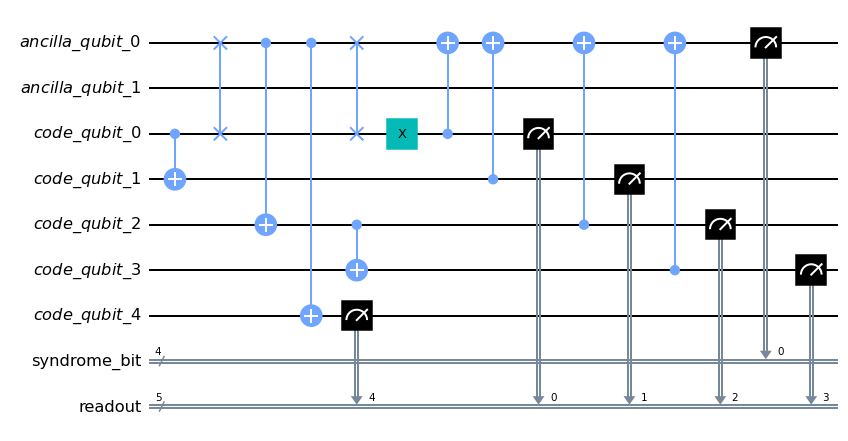

In [33]:
circuit = QuantumCircuit( cReg, readout, aReg, qReg )

#circuit.h(qReg[0])

# Encode the state
circuit.cx( qReg[0], qReg[1] )
circuit.swap( qReg[0], aReg[0] )
circuit.cx( aReg[0], qReg[2] )
circuit.cx( aReg[0], qReg[4] )
circuit.cx( qReg[2], qReg[3] )
circuit.swap( qReg[0], aReg[0] )

# Manual errors
circuit.x(qReg[0])

# Stabilizer 1: XZZXI
generator_1( circuit )


counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)

circuit.draw(output='mpl')

# Testing around with encoding the logical 0 #

{'0000000': 128, '0011101': 117, '0101110': 140, '0110011': 120, '1001000': 124, '1010101': 120, '1100110': 147, '1111011': 128}


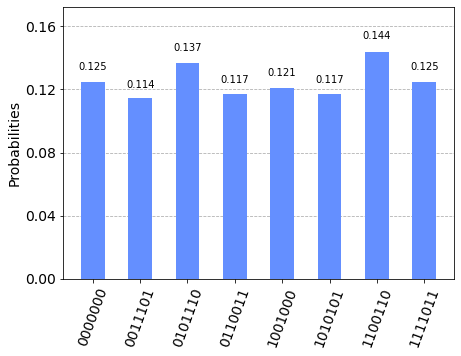

In [39]:
# Define our registers and circuit
q = QuantumRegister(7, 'code_qubit')
readout = ClassicalRegister(7, 'readout')
circuit = QuantumCircuit( readout, q )

#circuit.h(qReg[0])

# Encode the state
circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[3])

circuit.cx(q[0], q[2])
circuit.cx(q[3], q[5])
circuit.cx(q[1], q[6])

circuit.cx(q[0], q[4])
circuit.cx(q[3], q[6])
circuit.cx(q[1], q[5])

circuit.cx(q[0], q[6])
circuit.cx(q[1], q[2])
circuit.cx(q[3], q[5])

circuit.measure(q, readout)

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)

circuit.draw(output='mpl')
plot_histogram(counts)

In [57]:
def generator_1( circuit, q ):
    circuit.x(q[0])
    circuit.z(q[1])
    circuit.z(q[2])
    circuit.x(q[3])
    return

def generator_2( circuit, q ):
    circuit.x(q[1])
    circuit.z(q[2])
    circuit.z(q[3])
    circuit.x(q[4])
    return

def generator_3( circuit, q ):
    circuit.x(q[2])
    circuit.z(q[3])
    circuit.z(q[4])
    circuit.x(q[0])
    return

def generator_4( circuit, q ):
    circuit.x(q[3])
    circuit.z(q[4])
    circuit.z(q[0])
    circuit.x(q[1])
    return

{'00000': 66, '10001': 60, '10010': 70, '10100': 55, '10111': 65, '11000': 55, '11011': 61, '11101': 59, '11110': 49, '00011': 87, '00101': 80, '00110': 66, '01001': 63, '01010': 64, '01100': 65, '01111': 59}


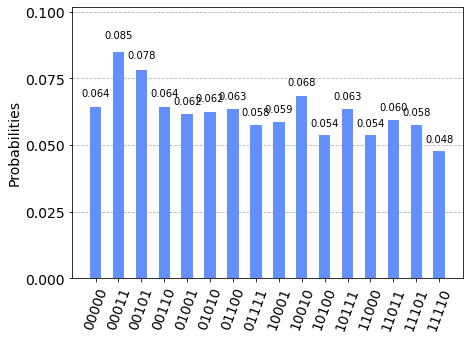

In [56]:
# Define our registers and circuit
q = QuantumRegister(5, 'code_qubit')
readout = ClassicalRegister(5, 'readout')
circuit = QuantumCircuit( readout, q )


# Encode the state
#circuit.x(q[0])
circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.h(q[3])

circuit.cx(q[0], q[1])
circuit.cx(q[0], q[2])
circuit.cx(q[0], q[3])
circuit.cx(q[0], q[4])

circuit.cx(q[1], q[2])
circuit.cx(q[1], q[3])
circuit.cx(q[1], q[4])

circuit.cx(q[2], q[3])
circuit.cx(q[2], q[4])

circuit.cx(q[3], q[4])

circuit.measure(q, readout)

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)


plot_histogram(counts)
#circuit.draw(output='mpl')

{'10000': 68, '10001': 70, '10010': 66, '10011': 58, '10100': 70, '10101': 65, '10110': 69, '10111': 53, '11000': 76, '11001': 55, '11010': 67, '11011': 68, '11100': 56, '11101': 55, '11110': 56, '11111': 72}


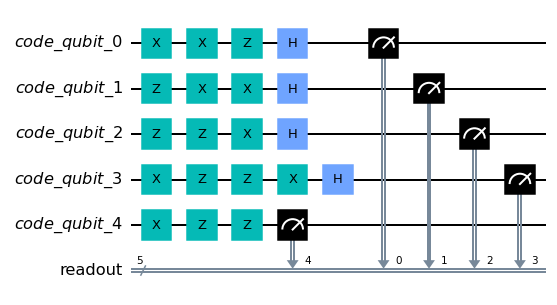

In [67]:
# Define our registers and circuit
q = QuantumRegister(5, 'code_qubit')
readout = ClassicalRegister(5, 'readout')
circuit = QuantumCircuit( readout, q )


# Encode the state


generator_1( circuit, q )
generator_2( circuit, q )
generator_3( circuit, q )
generator_4( circuit, q )
circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.h(q[3])
circuit.measure(q, readout)

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)


plot_histogram(counts)
circuit.draw(output='mpl')

# Testing with graphdecoders #

In [7]:
qReg = QuantumRegister(3, 'code_qubit')
aReg = QuantumRegister(2, 'ancilla_qubit')
cReg = ClassicalRegister(2, 'syndrome_bit')
readout = ClassicalRegister(3, 'readout')
circuit = QuantumCircuit( cReg, readout, aReg, qReg )

# Encoding
circuit.h(qReg[0])
circuit.cx(qReg[0], qReg[1])
circuit.cx(qReg[0], qReg[2])

# Manual errors
#circuit.x(qReg[2])

# Syndrome measurements Z1Z2
circuit.cx(qReg[0], aReg[0])
circuit.cx(qReg[1], aReg[0])
circuit.measure(aReg[0], cReg[0])

# Syndrome measurement Z2Z3
circuit.cx(qReg[1], aReg[1])
circuit.cx(qReg[2], aReg[1])
circuit.measure(aReg[1], cReg[1])

# Conditional corrections
#circuit.x(qReg[0]).c_if(cReg, 1) # The value can be written in base 10, but is interpreted as binary (to allow e.g. 01)
#circuit.x(qReg[1]).c_if(cReg, 3)
#circuit.x(qReg[2]).c_if(cReg, 2)

# Readout the state
circuit.barrier(qReg)
circuit.measure(qReg, readout)


counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
circuit.draw()


{'000 00': 511, '111 00': 513}


┌───┐┌───┐┌─┐                         
ancilla_qubit_0: ───────────────┤ X ├┤ X ├┤M├─────────────────────────
                                └─┬─┘└─┬─┘└╥┘┌───┐┌───┐┌─┐            
ancilla_qubit_1: ─────────────────┼────┼───╫─┤ X ├┤ X ├┤M├────────────
                 ┌───┐            │    │   ║ └─┬─┘└─┬─┘└╥┘ ░ ┌─┐      
   code_qubit_0: ┤ H ├──■────■────■────┼───╫───┼────┼───╫──░─┤M├──────
                 └───┘┌─┴─┐  │         │   ║   │    │   ║  ░ └╥┘┌─┐   
   code_qubit_1: ─────┤ X ├──┼─────────■───╫───■────┼───╫──░──╫─┤M├───
                      └───┘┌─┴─┐           ║        │   ║  ░  ║ └╥┘┌─┐
   code_qubit_2: ──────────┤ X ├───────────╫────────■───╫──░──╫──╫─┤M├
                           └───┘           ║            ║  ░  ║  ║ └╥┘
 syndrome_bit: 2/══════════════════════════╩════════════╩═════╬══╬══╬═
                                           0            1     ║  ║  ║ 
                                                              ║  ║  ║ 
      readout: 3/═════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_model

In [17]:

noise_model = get_noise(0.5, 0.5)
job = execute( circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=1000 )
raw_results = job.result().get_counts()
print(raw_results)


{'000 00': 42, '000 01': 33, '100 00': 31, '100 01': 25, '100 10': 34, '100 11': 21, '101 00': 28, '101 01': 32, '101 10': 35, '101 11': 30, '110 00': 23, '110 01': 30, '110 10': 34, '110 11': 20, '111 00': 43, '111 01': 39, '111 10': 24, '111 11': 34, '000 10': 33, '000 11': 36, '001 00': 30, '001 01': 31, '001 10': 29, '001 11': 35, '010 00': 30, '010 01': 27, '010 10': 35, '010 11': 24, '011 00': 25, '011 01': 29, '011 10': 31, '011 11': 47}


In [28]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.ignis.verification.topological_codes import lookuptable_decoding, postselection_decoding
dec = GraphDecoder( RepetitionCode(3,1) )
dec.matching('0 1  10')
#dec = GraphDecoder( circuit )

'1 1'

In [32]:
print(counts[0])

KeyError: 0